<a href="https://colab.research.google.com/github/sanazgit/OpenCV/blob/main/SkinDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!unzip '/content/drive/MyDrive/OpenCV/Face_Dataset.zip'

Archive:  /content/drive/MyDrive/OpenCV/Face_Dataset.zip
replace Ground_Truth/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [45]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from collections import defaultdict

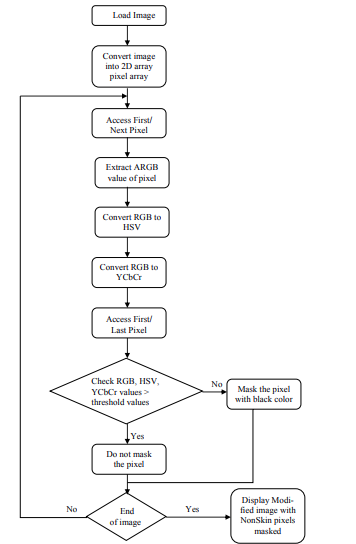

This is Type of image: <class 'numpy.ndarray'>
Shape: (400, 320, 3)


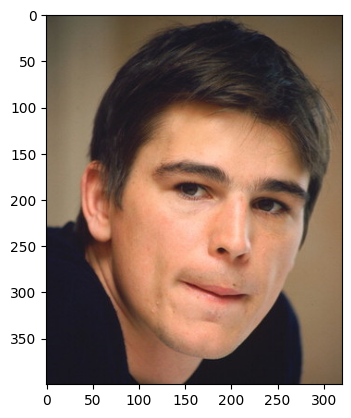

In [60]:
img = cv.imread('/content/Pratheepan_Dataset/FacePhoto/josh-hartnett-Poster-thumb.jpg')
print(f"This is Type of image: {type(img)}\nShape: {img.shape}")
plt.imshow(img[...,::-1]);

In [47]:
def metrics_from_confusion(tp, fp, fn, tn):
    eps = 1e-9
    acc = (tp + tn) / max(tp + fp + fn + tn, 1)
    prec = tp / max(tp + fp, eps)
    rec = tp / max(tp + fn, eps)
    f1 = 2 * prec * rec / max(prec + rec, eps)
    iou = tp / max(tp + fp + fn, eps)
    return acc, prec, rec, f1, iou


def binarize_mask(mask, thresh=128):
    if mask.ndim == 3:
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    _, bw = cv.threshold(mask, thresh, 255, cv.THRESH_BINARY)
    return bw

def skin_mask_opencv(img_bgr):

    img = cv.bilateralFilter(img_bgr, d=7, sigmaColor=75, sigmaSpace=75)

    # HSV
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    H, S, V = cv.split(hsv)
    S_low, S_high = int(0.23*255), int(0.68*255)     # 59–173
    cond_hsv = (H >= 0) & (H <= 25) & (S >= S_low) & (S <= S_high) & (V > 50)

    # YCrCb
    ycc = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv.split(ycc)
    cond_ycc = (Cr >= 135) & (Cr <= 180) & (Cb >= 85) & (Cb <= 135) & (Y > 50)

    mask = (cond_hsv | cond_ycc).astype(np.uint8) * 255

    # Morph
    k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, k, iterations=1)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, k, iterations=2)
    return mask


In [48]:
def skin_detection(img_dir, gt_dir, out_dir=None,
                    gt_suffix=None, gt_exts=(".png", ".jpg", ".jpeg")):
    os.makedirs(out_dir, exist_ok=True) if out_dir else None

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.*")))
    exts_ok = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")

    per_image_stats = []
    totals = defaultdict(int)  # tp, fp, fn, tn

    for img_path in img_paths:
        if not img_path.lower().endswith(exts_ok):
            continue

        name = os.path.splitext(os.path.basename(img_path))[0]


        gt_path = None
        if gt_suffix:

            for ext in gt_exts:
                cand = os.path.join(gt_dir, f"{name}{gt_suffix}{ext}")
                if os.path.isfile(cand):
                    gt_path = cand
                    break
        else:

            for ext in gt_exts:
                cand = os.path.join(gt_dir, f"{name}{ext}")
                if os.path.isfile(cand):
                    gt_path = cand
                    break

        if gt_path is None:
            print(f"[warn] GT not found for: {name}")
            continue


        img = cv.imread(img_path, cv.IMREAD_COLOR)
        gt = cv.imread(gt_path, cv.IMREAD_GRAYSCALE)

        if img is None or gt is None:
            print(f"[warn] failed to read: {name}")
            continue


        if (gt.shape[0] != img.shape[0]) or (gt.shape[1] != img.shape[1]):
            gt = cv.resize(gt, (img.shape[1], img.shape[0]), interpolation=cv.INTER_NEAREST)


        gt_bw = binarize_mask(gt, 128)


        pred = skin_mask_opencv(img)

        gt_bin = (gt_bw > 0)
        pr_bin = (pred > 0)

        tp = int(np.logical_and(pr_bin, gt_bin).sum())
        fp = int(np.logical_and(pr_bin, np.logical_not(gt_bin)).sum())
        fn = int(np.logical_and(np.logical_not(pr_bin), gt_bin).sum())
        tn = int(np.logical_and(np.logical_not(pr_bin), np.logical_not(gt_bin)).sum())

        acc, prec, rec, f1, iou = metrics_from_confusion(tp, fp, fn, tn)
        per_image_stats.append((name, acc, prec, rec, f1, iou))

        totals["tp"] += tp; totals["fp"] += fp
        totals["fn"] += fn; totals["tn"] += tn


        if out_dir:
            cv.imwrite(os.path.join(out_dir, f"{name}_mask.png"), pred)

            vis = cv.bitwise_and(img, img, mask=pred)
            cv.imwrite(os.path.join(out_dir, f"{name}_vis.png"), vis)


    tp, fp, fn, tn = totals["tp"], totals["fp"], totals["fn"], totals["tn"]
    g_acc, g_prec, g_rec, g_f1, g_iou = metrics_from_confusion(tp, fp, fn, tn)

    print("Per-image metrics (ACC / PREC / REC / F1 / IoU):")
    for name, acc, prec, rec, f1, iou in per_image_stats:
        print(f"{name:>20s} | {acc:.4f} {prec:.4f} {rec:.4f} {f1:.4f} {iou:.4f}")

    print("\n=== Global (micro) ===")
    print(f"Accuracy:  {g_acc:.4f}")
    print(f"Precision: {g_prec:.4f}")
    print(f"Recall:    {g_rec:.4f}")
    print(f"F1-score:  {g_f1:.4f}")
    print(f"IoU:       {g_iou:.4f}")

    return (g_acc, g_prec, g_rec, g_f1, g_iou), per_image_stats

In [49]:
img_dir = "/content/Pratheepan_Dataset/FacePhoto"
gt_dir  = "/content/Ground_Truth/GroundT_FacePhoto"
out_dir = "/content/outputs"

gt_suffix = None

global_metrics, per_image = skin_detection(img_dir, gt_dir, out_dir, gt_suffix)

Per-image metrics (ACC / PREC / REC / F1 / IoU):
          0520962400 | 0.4901 0.2385 0.9516 0.3814 0.2357
         06Apr03Face | 0.7202 0.6145 0.9986 0.7608 0.6140
   124511719065943_2 | 0.9004 0.6443 0.9265 0.7600 0.6130
         920480_f520 | 0.7717 0.5325 0.9833 0.6908 0.5277
Aishwarya-Rai_20091229_aatheory | 0.8188 0.6264 0.9985 0.7699 0.6258
    Kishani_-__n_-_5 | 0.9777 0.8653 0.9905 0.9237 0.8582
Matthew_narrowweb__300x381,0 | 0.7988 0.6781 0.9993 0.8079 0.6777
Megan-Fox-Pretty-Face-1-1024x768 | 0.9482 0.8328 0.9731 0.8975 0.8140
Salma-Hayek-face-wi-new-lg | 0.9233 0.8218 0.9987 0.9017 0.8209
Srilankan-Actress-Yamuna-Erandathi-001 | 0.3793 0.3210 0.9963 0.4856 0.3206
Srilankan-Actress-Yamuna-Erandathi-002 | 0.5166 0.2501 0.9629 0.3971 0.2477
  amida-belly-dancer | 0.8203 0.5910 0.9403 0.7258 0.5696
      chenhao0017me9 | 0.9394 0.7161 0.9983 0.8340 0.7152
    dulani_anuradha4 | 0.4933 0.3282 0.7826 0.4625 0.3008
    dulani_anuradha7 | 0.7144 0.5796 0.9488 0.7196 0.5620
evangeli

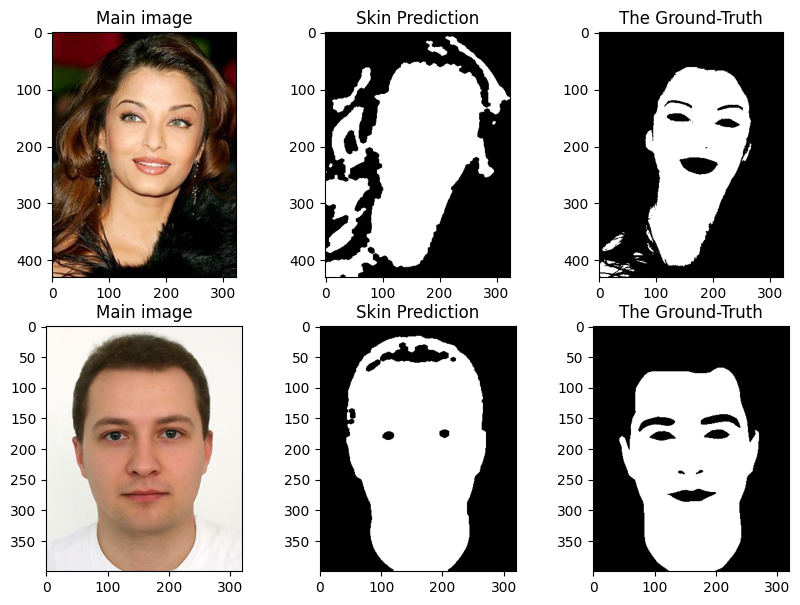

In [57]:
img_1 = cv.imread("/content/Pratheepan_Dataset/FacePhoto/Aishwarya-Rai_20091229_aatheory.jpg")
pred_1 = cv.imread("/content/outputs/Aishwarya-Rai_20091229_aatheory_mask.png", cv.IMREAD_GRAYSCALE)
gt_1  = cv.imread("/content/Ground_Truth/GroundT_FacePhoto/Aishwarya-Rai_20091229_aatheory.png", cv.IMREAD_GRAYSCALE)

img_rgb_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)

img_2 = cv.imread("/content/Pratheepan_Dataset/FacePhoto/m_unsexy_gr.jpg")
pred_2 = cv.imread("/content/outputs/m_unsexy_gr_mask.png", cv.IMREAD_GRAYSCALE)
gt_2 = cv.imread("/content/Ground_Truth/GroundT_FacePhoto/m_unsexy_gr.png", cv.IMREAD_GRAYSCALE)

img_rgb_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)

plt.figure(figsize=[10,7])

plt.subplot(231);plt.imshow(img_rgb_1);plt.title("Main image");
plt.subplot(232);plt.imshow(pred_1, cmap='gray');plt.title("Skin Prediction");
plt.subplot(233);plt.imshow(gt_1,  cmap='gray');plt.title("The Ground-Truth");


plt.subplot(234);plt.imshow(img_rgb_2);plt.title("Main image");
plt.subplot(235);plt.imshow(pred_2 ,  cmap='gray');plt.title("Skin Prediction");
plt.subplot(236);plt.imshow(gt_2 ,  cmap='gray');plt.title("The Ground-Truth");
